In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import pickle
from typing import List

In [2]:
TARGET_NAME = 'duration'

def prepare_target(data):
    data[TARGET_NAME] = data.tpep_dropoff_datetime - data.tpep_pickup_datetime
    data[TARGET_NAME] = data[TARGET_NAME].apply(lambda td: td.total_seconds() / 60)
    return data

def read_data(filename: str):
    data = pd.read_parquet(filename)
    data = prepare_target(data)
    return data

def drop_outliers(data):
    data = data[(data[TARGET_NAME] >= 1) & (data[TARGET_NAME] <= 60)]
    return data

def as_dict(data, categorical_vars: List[str] = ['PULocationID', 'DOLocationID']):
    data[categorical_vars] = data[categorical_vars].astype(str)
    data_dicts = data[categorical_vars].to_dict(orient='records')
    return data_dicts

In [ ]:
!mkdir -p data
!cd data
!wget https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-01.parquet
!wget https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-02.parquet

In [3]:
train_file = 'data/yellow_tripdata_2022-01.parquet'
valid_file = 'data/yellow_tripdata_2022-02.parquet'
train = read_data(train_file)
valid = read_data(valid_file)

In [4]:
# Q1: +1 column for duration added
train.shape, valid.shape

((2463931, 20), (2979431, 20))

In [5]:
# Q2
train.duration.std()

46.44530513776802

In [5]:
# Q3
((train.duration >= 1) & (train.duration <= 60)).mean()

0.9827547930522406

In [8]:
train = drop_outliers(train)
valid = drop_outliers(valid)
train.shape

(2421440, 20)

In [9]:
train_dicts = as_dict(train)
valid_dicts = as_dict(valid)

In [10]:
# Q4
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)
X_valid = dv.transform(valid_dicts)

In [12]:
len(dv.feature_names_), X_train.shape, X_valid.shape

(515, (2421440, 515))

In [11]:
y_train = train[TARGET_NAME].values
y_valid = valid[TARGET_NAME].values

In [12]:
# Q5
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [13]:
y_train_pred = lr.predict(X_train)
mean_squared_error(y_train, y_train_pred, squared=False)

6.986190135965422

/home/alina/anaconda3/envs/transcriber/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.
/home/alina/anaconda3/envs/transcriber/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



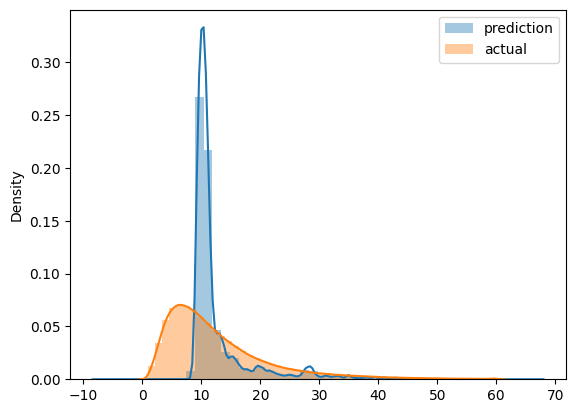

In [14]:
sns.distplot(y_train_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [15]:
# Q6
y_valid_pred = lr.predict(X_valid)
mean_squared_error(y_valid, y_valid_pred, squared=False)

7.786389475949743

In [17]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)